In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images


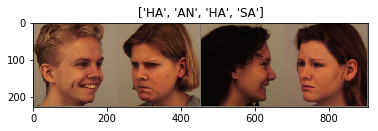

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet50.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

writer = SummaryWriter('./logs/resnet50_full')

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=20)

Epoch 0/19
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1163/1163 [01:50<00:00, 10.53it/s]


train Loss: 1.1873 Acc: 0.5522


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 15.95it/s]


val Loss: 0.4485 Acc: 0.8286

Epoch 1/19
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1163/1163 [01:47<00:00, 10.79it/s]


train Loss: 0.6201 Acc: 0.7941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 17.59it/s]


val Loss: 0.3299 Acc: 0.8816

Epoch 2/19
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1163/1163 [01:47<00:00, 10.78it/s]


train Loss: 0.4070 Acc: 0.8650


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 16.98it/s]


val Loss: 0.3848 Acc: 0.8571

Epoch 3/19
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1163/1163 [01:50<00:00, 10.53it/s]


train Loss: 0.3430 Acc: 0.8897


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 16.71it/s]


val Loss: 0.1783 Acc: 0.9224

Epoch 4/19
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1163/1163 [01:57<00:00,  9.87it/s]


train Loss: 0.2654 Acc: 0.9168


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 17.31it/s]


val Loss: 0.3067 Acc: 0.8980

Epoch 5/19
----------


100%|██████████████████████████████████████████████████████████████████████████████| 1163/1163 [01:50<00:00, 10.57it/s]


train Loss: 0.1916 Acc: 0.9387


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:03<00:00, 17.54it/s]


val Loss: 0.1742 Acc: 0.9306

Epoch 6/19
----------


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1151/1163 [01:55<00:01,  9.94it/s]

KeyboardInterrupt: 

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1151/1163 [02:10<00:01,  8.85it/s]

In [33]:
model_ft.load_state_dict(torch.load('saved/resnet50.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [35]:
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])
print(correct, total)


  6%|████▉                                                                            | 15/245 [00:02<00:37,  6.19it/s]

image no  20   original class :  AF   predicted class:  SA



 12%|█████████▉                                                                       | 30/245 [00:02<00:19, 10.80it/s]

image no  34   original class :  DI   predicted class:  AN



 14%|███████████▏                                                                     | 34/245 [00:02<00:17, 11.80it/s]

image no  38   original class :  SU   predicted class:  AF



 16%|████████████▌                                                                    | 38/245 [00:02<00:16, 12.68it/s]

image no  43   original class :  SA   predicted class:  AN



 20%|███████████████▊                                                                 | 48/245 [00:03<00:13, 14.79it/s]

image no  51   original class :  AF   predicted class:  HA



 24%|███████████████████▊                                                             | 60/245 [00:03<00:10, 16.82it/s]

image no  62   original class :  AF   predicted class:  SA
image no  63   original class :  AF   predicted class:  SU



 26%|█████████████████████▏                                                           | 64/245 [00:03<00:10, 17.30it/s]

image no  65   original class :  SU   predicted class:  AF



 32%|█████████████████████████▊                                                       | 78/245 [00:04<00:08, 19.30it/s]

image no  82   original class :  DI   predicted class:  AN



 38%|██████████████████████████████▋                                                  | 93/245 [00:04<00:07, 21.16it/s]

image no  95   original class :  DI   predicted class:  NE
image no  97   original class :  SU   predicted class:  AF



 40%|████████████████████████████████▍                                                | 98/245 [00:04<00:06, 21.40it/s]

image no  103   original class :  AF   predicted class:  SU



 46%|████████████████████████████████████▌                                           | 112/245 [00:04<00:05, 22.77it/s]

image no  117   original class :  SA   predicted class:  DI



 58%|██████████████████████████████████████████████▋                                 | 143/245 [00:05<00:03, 25.57it/s]

image no  146   original class :  SU   predicted class:  AF



 60%|████████████████████████████████████████████████▎                               | 148/245 [00:05<00:03, 25.80it/s]

image no  150   original class :  DI   predicted class:  AN



 64%|███████████████████████████████████████████████████▌                            | 158/245 [00:06<00:03, 26.33it/s]

image no  161   original class :  SU   predicted class:  AF



 77%|█████████████████████████████████████████████████████████████▍                  | 188/245 [00:06<00:02, 28.13it/s]

image no  192   original class :  DI   predicted class:  AN



100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:07<00:00, 30.73it/s]

228 245


In [26]:
str(total)

'1'